#### **Density Profile Comparisons**:

Notebook for calculation of 2D and 3D density profiles of galaxies, dark matter, and gas.

In [1]:
import numpy as np
import illustris_python as il
import matplotlib.colors as colors
import matplotlib.pyplot as plt 
from matplotlib.patches import Circle
import seaborn as sns
import h5py
from astropy.cosmology import Planck15 as cosmo
import astropy.constants as const
import astropy.units as u
        
from scipy.signal import savgol_filter
from colossus.halo import profile_nfw
from colossus.cosmology import cosmology as colossus_cosmo
from colossus.halo import concentration
import emcee
import scipy
from scipy.interpolate import UnivariateSpline
import corner
import sys

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))


%config IPCompleter.greedy = True
%config InlineBackend.figure_format ='retina'

sns.set(style = "ticks")
pi = np.pi
cosmo_col = colossus_cosmo.setCosmology('planck15');

snapshot_ind = 99

basePath = '/global/cscratch1/sd/samgolds/IllustrisTNG/TNG-300_3/outputs/'
basePath_dark = '/global/cscratch1/sd/samgolds/IllustrisTNG/TNG-300_3_Dark/outputs/'

snap_dir_g = basePath+'snapdir_0{}/snap_0{}.0.hdf5'.format(snapshot_ind, snapshot_ind)
snap_dir_dark = basePath_dark+'snapdir_0{}/snap_0{}.0.hdf5'.format(snapshot_ind, snapshot_ind)

matching_cat_path = basePath+'subhalo_matching_to_dark.hdf5'

# Load header file and halo group catalog
header = il.groupcat.loadHeader(basePath, snapshot_ind)
header_dark = il.groupcat.loadHeader(basePath_dark, snapshot_ind)

halo_grp_fields = ['GroupCM', 'GroupMass', 'Group_M_Crit200', 'Group_M_Mean200', 
                   'Group_R_Crit200', 'Group_R_Mean200', 'GroupFirstSub', 'GroupPos']
halo_grp = il.groupcat.loadHalos(basePath, snapshot_ind, fields=halo_grp_fields)
halo_grp['has_gas'] = True

header_dark = il.groupcat.loadHeader(basePath_dark, snapshot_ind)
halo_grp_fields_dark = ['GroupCM', 'GroupMass', 'Group_M_Crit200', 'Group_M_Mean200', 
                        'Group_R_Crit200', 'Group_R_Mean200', 'GroupFirstSub', 'GroupPos']
halo_grp_dark = il.groupcat.loadHalos(basePath_dark, snapshot_ind, fields=halo_grp_fields_dark)
halo_grp_dark['has_gas'] = False

# Obtain basic cosmological info and compute conversion factors
redshift = header['Redshift']
H = cosmo.H(redshift)
H0 = cosmo.H(0)
h = H0.value/100

# Define box boundary vector in Mpc (for period bcs)
boxsize = header['BoxSize'] # kpc/h
box_bounds = boxsize*np.ones(3)/1000

# Get DM Particle mass
with h5py.File(snap_dir_dark, 'r') as f:
    snap_dark = dict(f['Header'].attrs.items())

with h5py.File(snap_dir_g, 'r') as f:
    snap_g = dict(f['Header'].attrs.items())
    
dm_part_mass_dark = snap_dark['MassTable'][1]*10**10/h # Mass in solar mass
dm_part_mass = snap_g['MassTable'][1]*10**10/h

#### **Pick Subset of Halos to Analyze**:

Specify a subset of halos from TNG-300_3 and TNG-300_3_Dark catalogs to perform analysis on.

Number of Baryonic Halos: 234
Number of DMO Halos: 240


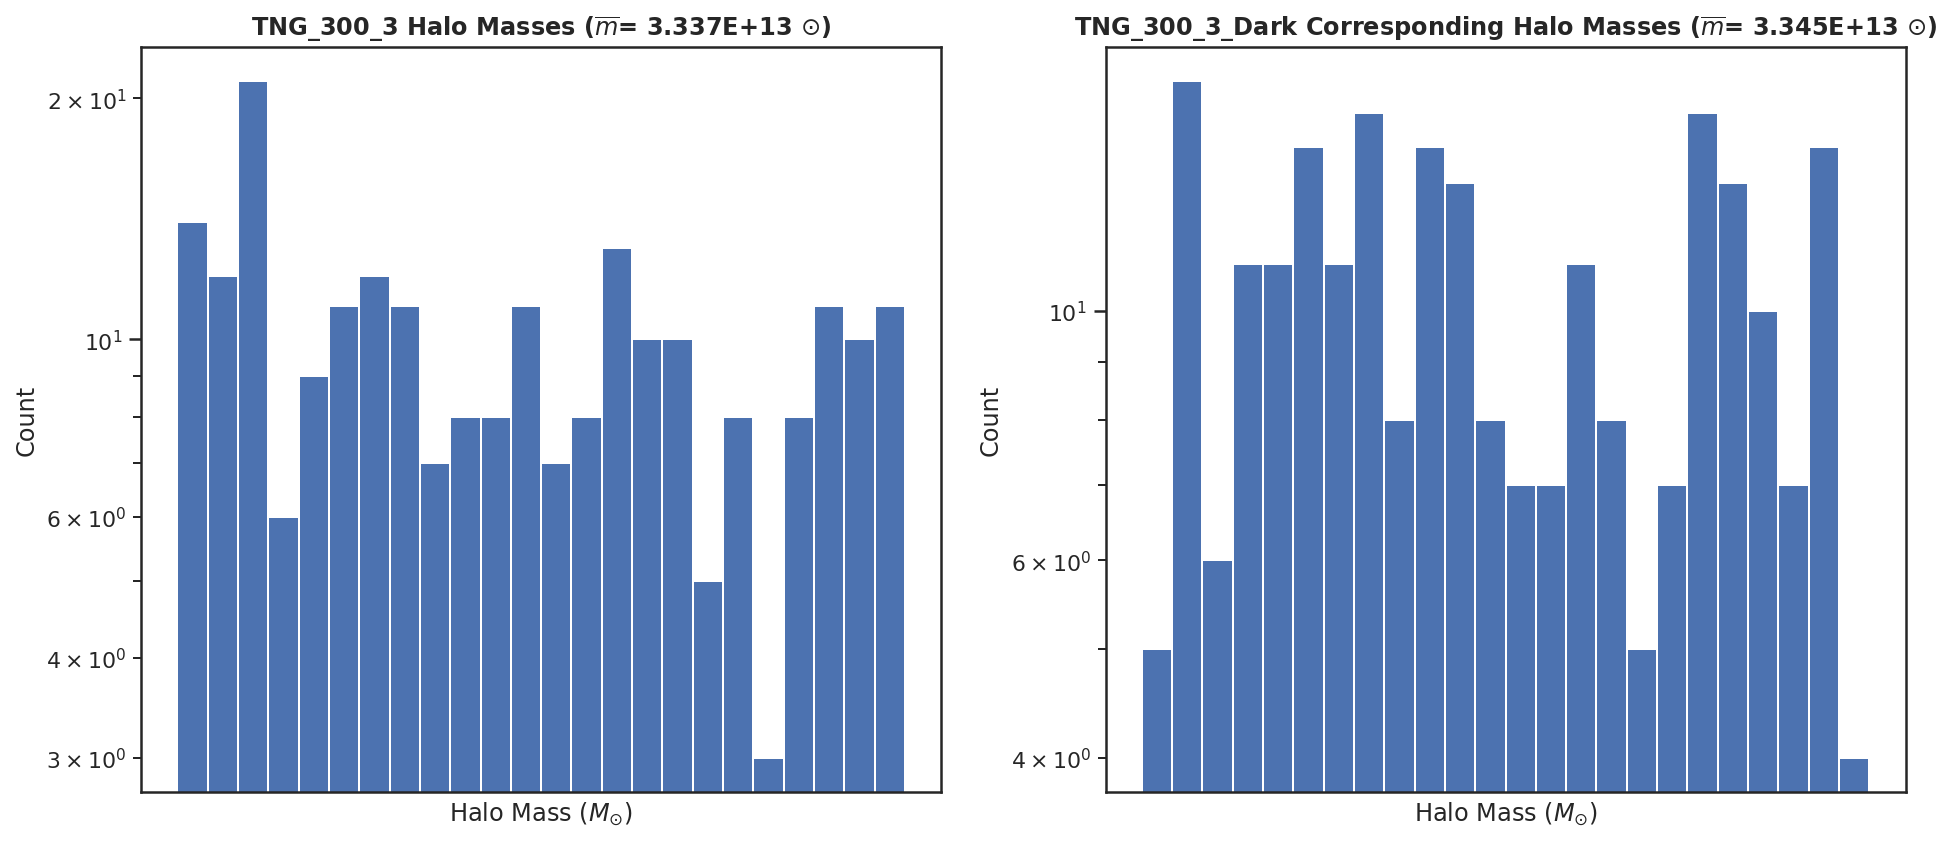

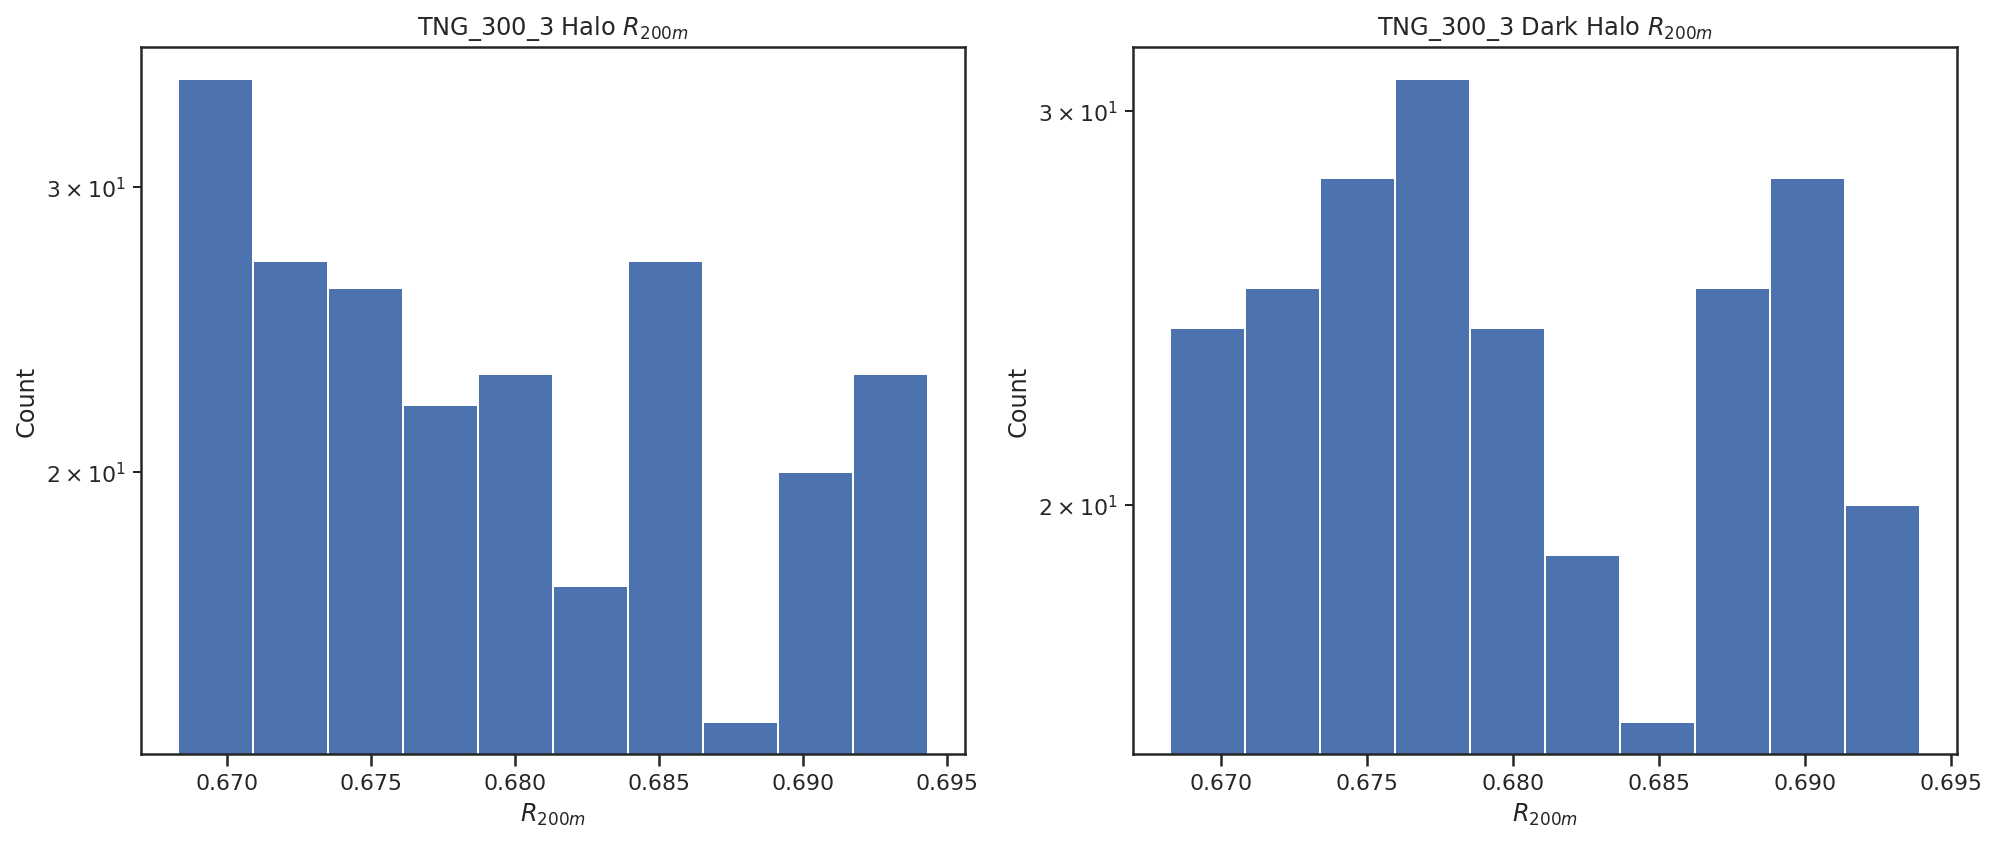

In [2]:
# Select halos in some mass interval between 10^13.5 and 10^14 solar mass
halo_masses = halo_grp['Group_M_Mean200']*10**10/h
halo_masses_dark = halo_grp_dark['Group_M_Mean200']*10**10/h
halo_r200m = halo_grp['Group_R_Mean200']/1000
halo_r200m_dark = halo_grp_dark['Group_R_Mean200']/1000


mass_range = [10**13.50, 10**13.55]
halo_indices  = np.where((halo_masses >= mass_range[0]) & 
                (halo_masses <= mass_range[1]))[0]
halo_indices_dark = np.where((halo_masses_dark >= mass_range[0]) & 
                (halo_masses_dark <= mass_range[1]))[0]


def filter_multi_halo(halo_grp, halo_indices, cut_off):
    # Filter halos which have disagreement between CM and position of min potential
    
    dev = (halo_grp['GroupCM']-halo_grp['GroupPos'])[halo_indices]/1000

    for ind, q in enumerate(dev.T):
            q = np.where(np.abs(q) > 0.5 * box_bounds[ind], box_bounds[ind]-np.abs(q), q)
            dev.T[ind] = q

    r = np.linalg.norm(dev, axis=1)   
    r_frac = r/halo_grp['Group_R_Mean200'][halo_indices]*1000
    
    return halo_indices[np.where(r_frac < cut_off)]
    
# CUT_OFF = np.inf # Change if you want to apply a cutoff on |halo COM-location of min potential|
# halo_indices  = filter_multi_halo(halo_grp, halo_indices, CUT_OFF)
# halo_indices_dark  = filter_multi_halo(halo_grp_dark, halo_indices_dark, CUT_OFF)


# Plot quantities for selected haloes ##
print("Number of Baryonic Halos: "+str(len(halo_indices)))
print("Number of DMO Halos: "+str(len(halo_indices_dark)))

# Plot mass distributions
plt.figure(figsize=(14, 6))

plt.subplot(1,2,1)
bins = np.logspace(np.log10(mass_range[0]), np.log10(mass_range[1]), 25)

plt.hist(halo_masses[halo_indices], bins=bins)
title_str = r"TNG_300_3 Halo Masses ($\overline{m}$= "
title_str += ("{:.3E} $\odot$)").format(np.mean(halo_masses[halo_indices]))
plt.title(title_str, fontweight="bold")
plt.xlabel(r"Halo Mass ($M_{\odot}$)")
plt.ylabel("Count")
plt.xscale("log")
plt.yscale("log")

plt.subplot(1,2,2)

bins = np.logspace(np.log10(mass_range[0]), np.log10(mass_range[1]), 25)
plt.hist(halo_masses_dark[halo_indices_dark], bins=bins)
title_str = r"TNG_300_3_Dark Corresponding Halo Masses ($\overline{m}$= "
title_str += ("{:.3E} $\odot$)").format(np.mean(halo_masses_dark[halo_indices_dark]))

plt.title(title_str, fontweight="bold")
plt.xlabel(r"Halo Mass ($M_{\odot}$)")
plt.ylabel("Count")
plt.xscale("log")
plt.yscale("log")

plt.tight_layout()

# Plot R_200m Distributions:
plt.figure(figsize=(14, 6))

plt.subplot(1,2,1)

plt.hist(halo_r200m[halo_indices])
title_str = r"TNG_300_3 Halo $R_{200m}$"
plt.title(title_str)
plt.xlabel(r"$R_{200m}$")
plt.ylabel("Count")
plt.yscale("log")

plt.subplot(1,2,2)

plt.hist(halo_r200m_dark[halo_indices_dark])
title_str = r"TNG_300_3 Dark Halo $R_{200m}$"
plt.title(title_str)
plt.xlabel(r"$R_{200m}$")
plt.ylabel("Count")
plt.yscale("log")

plt.tight_layout()

##### **Compute Halo Density Profile:**

Compute 2D and 3D denstiy profiles of the dark matter and gas within a halo. The first cell loads the coordinates of all particles within 5 Mpc/h of the halo center for all haloes between 10^13.5 and 10^14 solar mass.

In [3]:
R_HALO = 5 # Value to bin halos up to in Mpch
BINS = np.logspace(-1, np.log10(R_HALO), 60) # Default bins for computing all halo profiles unless otherwise specified

# Load coordinate arrays
DM_COORDS_DARK = np.load(basePath_dark+"full_positions_0{}/dm_coords_dark_mass_sel.npy".format(snapshot_ind), 
                         allow_pickle=True)
DM_VELOC_DARK = np.load(basePath_dark+"full_positions_0{}/dm_veloc_dark_mass_sel.npy".format(snapshot_ind), 
                        allow_pickle=True)

DM_COORDS = np.load(basePath+"full_positions_0{}/dm_coords_mass_sel.npy".format(snapshot_ind), 
                    allow_pickle=True)
DM_VELOC = np.load(basePath+"full_positions_0{}/dm_veloc_mass_sel.npy".format(snapshot_ind), 
                   allow_pickle=True)

GAS_COORDS = np.load(basePath+"full_positions_0{}/gas_coords_mass_sel.npy".format(snapshot_ind), 
                     allow_pickle=True)
GAS_VELOC = np.load(basePath+"full_positions_0{}/gas_veloc_mass_sel.npy".format(snapshot_ind), 
                    allow_pickle=True)
GAS_MASSES = np.load(basePath+"full_positions_0{}/gas_mass_mass_sel.npy".format(snapshot_ind), 
                     allow_pickle=True)

STAR_COORDS = np.load(basePath+"full_positions_0{}/star_coords_mass_sel.npy".format(snapshot_ind), 
                      allow_pickle=True)
STAR_VELOC = np.load(basePath+"full_positions_0{}/star_veloc_mass_sel.npy".format(snapshot_ind), 
                     allow_pickle=True)
STAR_MASSES = np.load(basePath+"full_positions_0{}/star_mass_mass_sel.npy".format(snapshot_ind), 
                      allow_pickle=True)

BH_COORDS = np.load(basePath+"full_positions_0{}/bh_coords_mass_sel.npy".format(snapshot_ind), 
                    allow_pickle=True)
BH_VELOC = np.load(basePath+"full_positions_0{}/bh_veloc_mass_sel.npy".format(snapshot_ind), 
                   allow_pickle=True)
BH_MASSES = np.load(basePath+"full_positions_0{}/bh_mass_mass_sel.npy".format(snapshot_ind), 
                    allow_pickle=True)

# Load halo indices corresponding to coordinate arrays
HALO_INDICES_TOT = np.load(basePath+"full_positions_0{}/halo_indices_mass_sel.npy".format(snapshot_ind), 
                           allow_pickle=True)
HALO_INDICES_DARK_TOT = np.load(basePath_dark+"full_positions_0{}/halo_indices_dark_mass_sel.npy".format(snapshot_ind), 
                                allow_pickle=True)

In [4]:
def progress_bar(cur_val, final_val):
    """ 
    Function to keep track of progress during computations by displaying
    a progress bar

    Parameters:
    cur_val (int/float): current iteration/value calculation is on
    final_val (int/float): final iteration/value that calculation will take
    """

    bar_length = 20
    percent = float(cur_val) / final_val
    arrow = '-' * int(round(percent * bar_length)-1) + '>'
    spaces = ' ' * (bar_length - len(arrow))

    sys.stdout.write("\rProgress: [{0}]"
                     " {1}%".format(arrow + spaces, int(round(percent * 100))))
    sys.stdout.flush()
    

class HALO_PROFILE(object):
   
    """
    Class for storing and computing density profiles of a particular halo 

    """
    
    def __init__(self, halo_grp, halo_ind, bins=BINS, prof_key="tot"):
        
        """
        Initialize a HALO_PROFILE object. Compute relevent 3D density profiles
        
        Parameters:
        ----------
        halo_grp: dict
            The dictionary associated with the group catalog the halo is found in
            
        halo_ind: int
            The integer index of the halo within the halo_grp
            
        bins: float array
            Array containing the bin boundaries for computing the profiles
            
        """
        
        self._halo_grp = halo_grp
        self.halo_ind = halo_ind
        self.halo_cm = self._halo_grp['GroupCM'][self.halo_ind]/(1000)
        self.halo_cm = self._halo_grp['GroupPos'][self.halo_ind]/(1000)
        self.has_gas = self._halo_grp['has_gas']
        self.halo_bins=bins
        self.prof_key = prof_key
        
        # Load the associated halo and compute profiles
        if self.has_gas:
            
            # Load halos
            halo_dm = il.snapshot.loadHalo(basePath, snapshot_ind, self.halo_ind,'dm')
            halo_gas = il.snapshot.loadHalo(basePath, snapshot_ind, self.halo_ind, 'gas')
            
            # Load gas/dm positions
            coord_ind = np.where(HALO_INDICES_TOT==self.halo_ind)[0][0]
            self.halo_dm_pos = DM_COORDS[coord_ind]
            self.halo_gas_pos = GAS_COORDS[coord_ind]
            self.halo_gas_mass = GAS_MASSES[coord_ind]
            self.halo_star_pos = STAR_COORDS[coord_ind]
            self.halo_star_mass = STAR_MASSES[coord_ind]
            self.halo_bh_pos = BH_COORDS[coord_ind]
            self.halo_bh_mass = BH_MASSES[coord_ind]
            
            self.R_mean_200 = self._halo_grp['Group_R_Mean200'][self.halo_ind]/(1000)

            # Compute 3D profiles
            if self.prof_key == "tot":
                dm_weights = dm_part_mass*np.ones(len(self.halo_dm_pos))
                total_weights = np.concatenate((dm_weights, self.halo_gas_mass,  self.halo_star_mass, self.halo_bh_mass), axis=0)
                total_pos = np.concatenate((self.halo_dm_pos, self.halo_gas_pos,  self.halo_star_pos, self.halo_bh_pos), axis=0)
                self.profile_3d = self.compute_3D_density_profile(total_pos, total_weights)
                
            elif self.prof_key == "dm":
                self.profile_3d = self.compute_3D_density_profile(self.halo_dm_pos, 
                                                                  weights = dm_part_mass*np.ones(len(self.halo_dm_pos)))
            elif self.prof_key == "gas":
                self.profile_3d = self.compute_3D_density_profile(self.halo_gas_pos, weights = self.halo_gas_mass)
                
            elif self.prof_key == "star":
                self.profile_3d = self.compute_3D_density_profile(self.halo_star_pos, weights = self.halo_star_mass)

        else:
            # Load halo
            halo_dm = il.snapshot.loadHalo(basePath_dark, snapshot_ind, self.halo_ind,'dm')
            
            # Load dm positions
            coord_ind = np.where(HALO_INDICES_DARK_TOT==self.halo_ind)[0][0]
            self.halo_dm_pos = DM_COORDS_DARK[coord_ind]
            self.R_mean_200 = self._halo_grp['Group_R_Mean200'][self.halo_ind]/(1000)
        
            # Compute 3D profiles
            self.profile_3d = self.compute_3D_density_profile(self.halo_dm_pos, 
                                                              weights = dm_part_mass_dark*np.ones(len(self.halo_dm_pos)))
        
     
    def compute_3D_density_profile(self, positions, weights=None):
        
        """
        Initialize a HALO_PROFILE object. Compute relevent 3D density profiles
        
        Parameters:
        ----------
        positions: n*3 float array
             x, y, and z positions of particles
         
        Returns:
        -------
        average_bin_radius: float array 
            Average radial position of each density bin (Mpc)
            
        rho: array
            density of each radial bin (Counts/Mpc^3)
            
        """
        BINS_SINGLE = np.logspace(-2, 1, 1000) # Default bins for computing all halo profiles unless otherwise specified

        # Verify input has correct shape
        assert(len(positions.T==3))
        
        # Account for halos which go over the boundary
        dev = positions-self.halo_cm

        for ind, q in enumerate(dev.T):
            q = np.where(np.abs(q) > 0.5 * box_bounds[ind], box_bounds[ind]-np.abs(q), q)
            dev.T[ind] = q
    
        # Compute profile  
        r = np.linalg.norm(dev, axis=1)
        counts, r_edges = np.histogram(r, bins=self.halo_bins, weights=weights)
        
        average_bin_radius = 1/2*(r_edges[1:]+r_edges[0:-1])
        dV = 4/3*np.pi*(r_edges[1:]**3-r_edges[0:-1]**3)

        rho = counts/dV

        return average_bin_radius, rho

def compute_averaged_profiles(halo_grp, halo_indices, averaged_bins=BINS, prof_key="dm"):
    
    """
    Compute averaged profiles for a set of halos within a halo group
    
    Parameters:
    ----------
    halo_grp: dict
        The dictionary associated with the group catalog the halo is found in

    halo_indices: int array
        Array containing the integer indices of halos to be averaged
        
    averaged_bins: float array
        Array containing the bins to average profiles
    
    prof_key: string
        String indicating which profile to average (e.g. gas, dm, or total)

    Returns:
    -------
    averaged_r: array 
        Average radial position of each density bin (Mpc)

    averaged_rho: array
        density of each radial bin (Counts/Mpc^3)
        
    """
    
    possible_keys = ["gas", "dm", "tot", "star"]
    
    assert(prof_key in possible_keys)
    
    N_halo = len(halo_indices)
    n_bins = len(averaged_bins)-1
    
    r_mat = np.zeros((N_halo, n_bins))
    rho_mat = np.zeros((N_halo, n_bins))

    for i in range(N_halo):
        progress_bar(i, 2*N_halo)
        
        halo_ind = halo_indices[i]
        
        assert((halo_ind >= 0).all() & (halo_ind < halo_grp['count']).all())

        # Load associated halo profile object
        halo_profile = HALO_PROFILE(halo_grp, halo_ind, prof_key=prof_key)
        r = halo_profile.profile_3d[0]
        rho = halo_profile.profile_3d[1]        

        # Add results to array for averaging        
        r_mat[i] = r
        rho_mat[i] = rho

    # Compute average profile
    r_full = r_mat.flatten()
    rho_full = rho_mat.flatten()
    rho_ind = np.where(rho_full != 0)
    rho_ind = np.arange(len(rho_full))
    averaged_rho, averaged_r, binnumbers = scipy.stats.binned_statistic(r_full[rho_ind], rho_full[rho_ind], 
                                                                        'mean', averaged_bins)
    
    averaged_r = 1/2*(averaged_r[1:]+averaged_r[0:-1])

    
    # Remove any bins which don't have any points
    non_zero_indices = np.where(averaged_rho != 0)
    averaged_rho = averaged_rho[non_zero_indices]
    averaged_r = averaged_r[non_zero_indices]
    
    cov = np.zeros((n_bins, n_bins))
    
    for k in range(N_halo):
        progress_bar(2*k, 2*N_halo)
        
        rho_k = rho_mat[k]
        
        for i in range(n_bins):
            for j in range(n_bins):
               # cov[i][j] += (averaged_rho[i]-rho_k[i])*(averaged_rho[j]-rho_k[j])
                cov[i][j] += (rho_k[i]-averaged_rho[i])*(rho_k[j]-averaged_rho[j])
                
        progress_bar(2*(k+1), 2*N_halo)
                
    cov /= (N_halo-1)
    
                
    return averaged_r, averaged_rho, cov

### **Compute Average and NFW Profiles:**

Compute average profiles and estimate variance using jackknife.

In [5]:
print("Computing Profile for Full Snapshot: All Particles")
averaged_r_tot, averaged_rho_tot, cov = compute_averaged_profiles(halo_grp, halo_indices, prof_key="tot")

print("\n Computing Profile for Full Snapshot: DM")
averaged_r_dm, averaged_rho_dm, cov_dm = compute_averaged_profiles(halo_grp, halo_indices, prof_key="dm")

print("\n Computing Profile for Full Snapshot: Gas")
averaged_r_gas, averaged_rho_gas, cov_gas = compute_averaged_profiles(halo_grp, halo_indices, prof_key="gas")

print("\n Computing Profile for Full Snapshot: Stars")
averaged_r_stars, averaged_rho_stars, cov_stars = compute_averaged_profiles(halo_grp, halo_indices, prof_key="star")

Computing Profile for Full Snapshot: All Particles
Progress: [------------------->] 100%
 Computing Profile for Full Snapshot: DM
Progress: [------------------->] 100%
 Computing Profile for Full Snapshot: Gas
Progress: [------------------->] 100%
 Computing Profile for Full Snapshot: Stars
Progress: [------------------->] 100%

In [6]:
print("Computing Profile for Dark Snapshot: DM Only")
averaged_r_tot_dark, averaged_rho_tot_dark, cov_dark = compute_averaged_profiles(halo_grp_dark, halo_indices_dark, prof_key="tot")

Computing Profile for Dark Snapshot: DM Only
Progress: [------------------->] 100%

### **Plot Relative Profile Contributions**

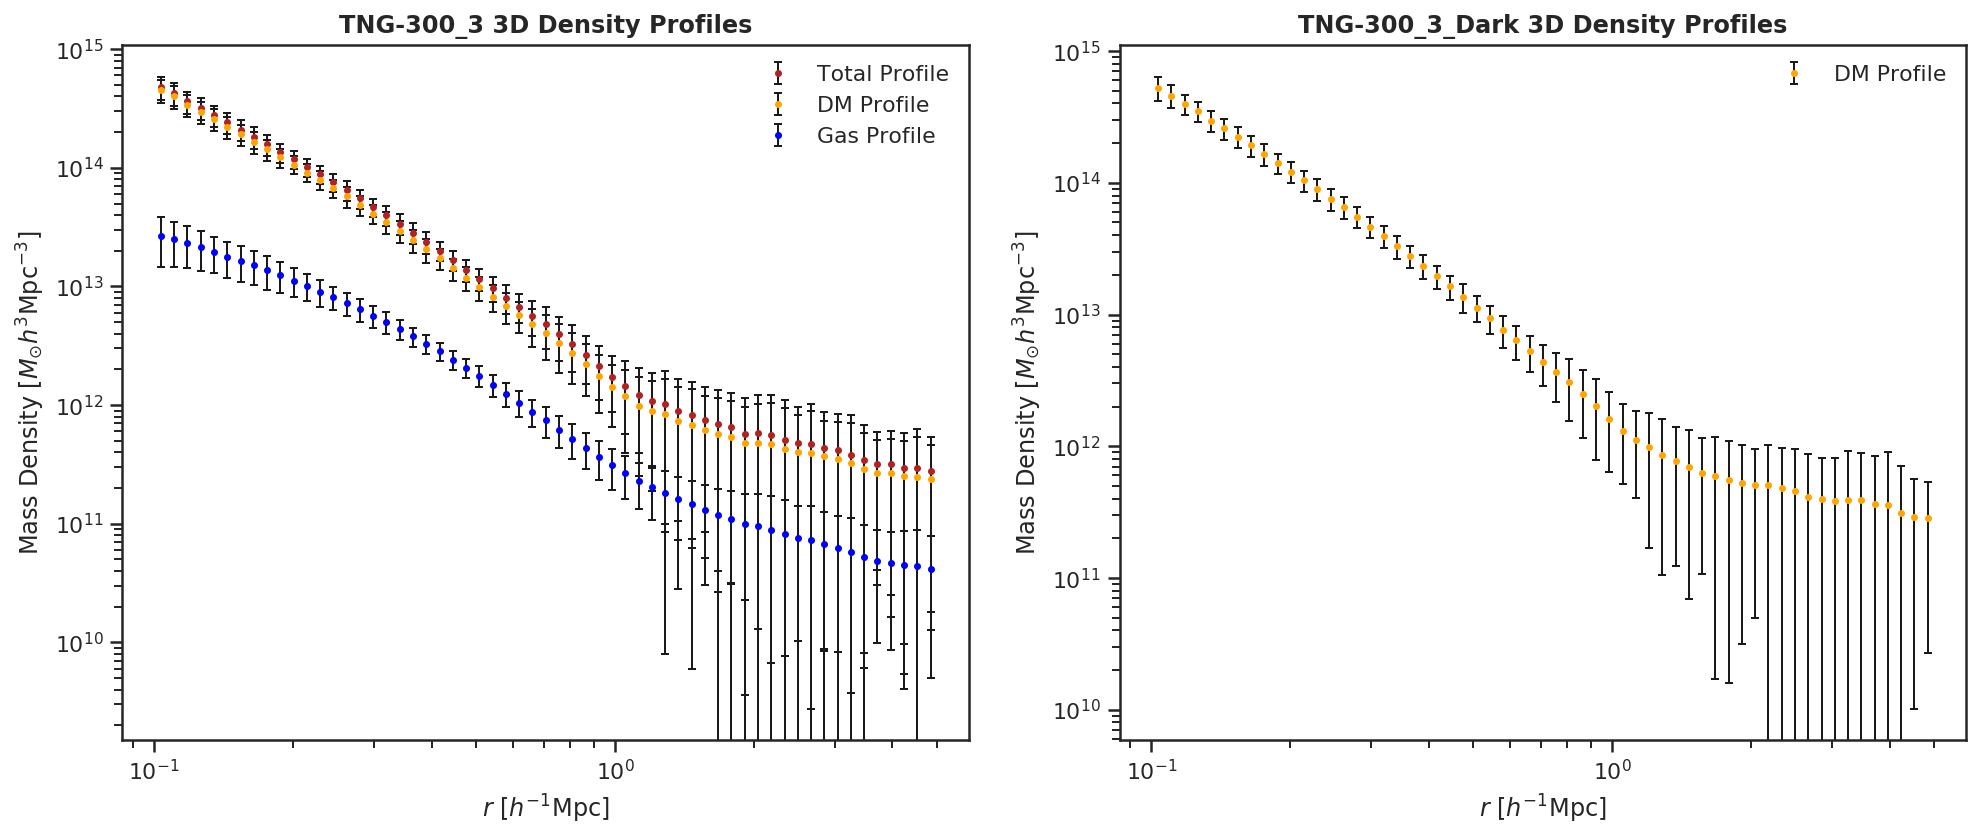

In [7]:
m_crit200_dark = np.mean(halo_grp_dark['Group_M_Crit200'][halo_indices_dark])
m_crit200 = np.mean(halo_grp['Group_M_Crit200'][halo_indices])

# Compute NFW Profile
c_crit200= concentration.concentration(m_crit200*10**10, mdef = '200c', z=redshift, model = 'bullock01')
p_nfw = profile_nfw.NFWProfile(M = m_crit200*10**10, 
                               c = c_crit200, z=redshift, mdef = '200c')

r_nfw = np.logspace(np.log10(np.min(averaged_r_tot)), 
                    np.log10(np.max(averaged_r_tot)), 1000)*(1000)
rho_nfw = p_nfw.density(r_nfw) # density in units of M_sun h^2/kpc^3
rho_nfw *= 1000**3/(H0.value/100) # Convert to M_sun/Mpc^3

"""---------------------------------------------------------------------------------"""
plt.figure(figsize=(14, 6))

plt.subplot(1,2,1)

plt.errorbar(averaged_r_tot, averaged_rho_tot, 
             yerr=np.sqrt(np.diag(cov)), 
             marker = '.', color = "firebrick", linestyle = "none",
             markersize = 5, ecolor = 'k', elinewidth = 1, capsize=2, 
             markeredgewidth=1, label=r"Total Profile")

plt.errorbar(averaged_r_dm, averaged_rho_dm, 
             yerr=np.sqrt(np.diag(cov_dm)), 
             marker = '.', color = "orange", linestyle = "none",
             markersize = 5, ecolor = 'k', elinewidth = 1, capsize=2, 
             markeredgewidth=1, label=r"DM Profile")

plt.errorbar(averaged_r_gas, averaged_rho_gas, 
             yerr=np.sqrt(np.diag(cov_gas)), 
             marker = '.', color = "blue", linestyle = "none",
             markersize = 5, ecolor = 'k', elinewidth = 1, capsize=2, 
             markeredgewidth=1, label=r"Gas Profile")

# plt.ylim(bottom= 10**11)


plt.title("TNG-300_3 3D Density Profiles", fontweight="bold")
plt.xlabel(r"$r$ [$h^{-1}$Mpc]")
plt.ylabel("Mass Density [$M_{\odot}h^3$Mpc$^{-3}$]")
plt.legend(frameon=False)
plt.xscale("log")
plt.yscale("log")


plt.subplot(1,2,2)

plt.errorbar(averaged_r_tot_dark, averaged_rho_tot_dark, 
             yerr=np.sqrt(np.diag(cov_dark)), 
             marker = '.', color = "orange", linestyle = "none",
             markersize = 5, ecolor = 'k', elinewidth = 1, capsize=2, 
             markeredgewidth=1, label=r"DM Profile")

plt.title("TNG-300_3_Dark 3D Density Profiles", fontweight="bold")
plt.xlabel(r"$r$ [$h^{-1}$Mpc]")
plt.ylabel("Mass Density [$M_{\odot}h^3$Mpc$^{-3}$]")
plt.legend(frameon=False)
plt.xscale("log")
plt.yscale("log")

plt.tight_layout()